# Introduction

In [1]:
%load_ext autoreload
%autoreload 2

In [249]:
import pandas as pd
import plotly.express as px

from ts import data
from ts import viz
from ts import dsp

# Pandas
Pandas is the most popular data manipulation and transformation library in Python. It is best suited for dataset small enough to fit in memory, although you can scale it using frameworks such as Dask. It is well known for having a bit of a funky interface compared to its peers in other languages (like R) or Spark. However, Pandas remain one of the most used tools for building data pipelines.  

Throughout this section, we will use Pandas to explore two small datasets, the global temp dataset, and the trump tweets dataset.

## Global Temp Data

In [30]:
# load data
df = data.load_globaltemp(frmt='pandas', mode='monthly')

# show first few rows to get a feeling of the schema
df.head()

,Source,Date,Mean
0,GCAG,2016-12,0.7895
1,GISTEMP,2016-12,0.8100
2,GCAG,2016-11,0.7504
3,GISTEMP,2016-11,0.9300
4,GCAG,2016-10,0.7292


I am not sure what the source here represent, so let's just compute the daily mean

In [40]:
daily_mean = (
    df
    .groupby('Date')
    .mean()
    .reset_index()
    .rename(columns={'Mean': 'temp'})
)
daily_mean.head(2)

,Date,temp
0,1880-01,-0.14955
1,1880-02,-0.16645


Now visualize

In [50]:
px.line(
    daily_mean, 
    x='Date', 
    y='temp', 
    title='Global Monthly Mean Temperature Since 1880'
)

We can clearly see two things happening in this timeseries. First there is clearly some seasonality, and second there is a trend started taking place somewhere in the mid 20th century

**Smoothing**
One thing we can easily do is apply a moving average to the timeseries to "smoothen" the plot. This corresponds to taking the average of points within a window. This ends up reducing the noise.

In [64]:
window_size = 5
win_type = None
daily_mean['smooth'] = daily_mean['temp'].rolling(window=window_size, win_type=win_type).mean()
px.line(
    daily_mean, 
    x='Date', 
    y='smooth', 
    title=f'Smoothed plot of Global Monthly Mean Temperature Since 1880 using a window size = {window_size}'
)

we can also manipulate with the `win_type` argument to control the weighting of different points within the window. For example, if we use `win_type = exponential`. For a fulll list of window types visit this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html).

In [81]:
window_size = 10
tau = 5
win_type = 'exponential'
daily_mean['smooth'] = daily_mean['temp'].rolling(window=window_specs, win_type=win_type).mean(tau=tau)

px.line(
    daily_mean, 
    x='Date', 
    y='smooth', 
    title=f'''
    Smoothed plot of Global Monthly Mean Temperature Since 1880 using <br>
    a window size = {window_size} and exponential window with tau = {tau}'''
)

## Trump Tweets
Now on to more interesting datasets. We will use the trump tweets dataset to show some cool features of pandas

In [88]:
df = data.load_trumptweets(frmt='pandas')
df.head(2)

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN


In my view, `df.info` provides the best summary for a pandas dataframe

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43352 entries, 0 to 43351
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         43352 non-null  int64 
 1   link       43352 non-null  object
 2   content    43352 non-null  object
 3   date       43352 non-null  object
 4   retweets   43352 non-null  int64 
 5   favorites  43352 non-null  int64 
 6   mentions   20386 non-null  object
 7   hashtags   5583 non-null   object
dtypes: int64(3), object(5)
memory usage: 2.6+ MB


as you can see the dataset has some columns that we dont care about, like the tweet id and linklet's get rid of these

In [112]:
dorp_cols = ['id', 'link']
df_light = df.drop(columns=dorp_cols)
df_light.head(2)

,content,date,retweets,favorites,mentions,hashtags
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN


Let's create some derivative datasets from this data. Our first time series could be the count of daily tweets. First, we need to parse the datetime coulmn as a datetime type, rather than a string (object). You'll find [this](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) link very helpful to determine the right date format. I find myself looking this up a lot! This is much faster than using the `infer_datetime` flag in `pd.to_datetime` and also safer

In [101]:
df_light['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S")

Now let's generate a time series of daily tweet count

In [111]:
daily_tweets_count = (
    df_light
    .set_index('date')
    .resample('1D')
    .count()
    .reset_index()
    .filter(items=['date', 'content'])
    .rename(columns={'content': 'count'})
)

daily_tweets_count.head()

,date,count
0,2009-05-04,2
1,2009-05-05,0
2,2009-05-06,0
3,2009-05-07,0
4,2009-05-08,2


 beautiful right! and all done through a clear chaining pipleine. Don't know why R peope always complaining about this in pandas. Now let's plot

In [115]:
px.line(
    daily_tweets_count, 
    x='date', 
    y='count', 
    title=f'''
    Daily count of trump tweets since 2009'''
)

Wow, what happend on January 2015? Let's query that specific day.

In [128]:
daily_tweets_count[daily_tweets_count['count'] == daily_tweets_count['count'].max()]

,date,count
2071,2015-01-04,155


In [162]:
from datetime import date

pd.set_option('display.max_colwidth', 1000)


df_light['day'] = df_light['date'].dt.date 

(
    df_light
    .query('day == @date(2015, 1, 4)')
    .filter(['content'])
)

,content
19573,"""@tbc_branding: To my biz-minded tweeps from # SharkTankNation # Restaurantstartup # theprofit...I'll see you 2nite for # CelebrityApprentice"
19574,""" @ DavidThomasNo1: Tune in for some late night viewing of @ realDonaldTrump on celebrity apprentice USA @ BBCOne tonight"""
19575,""" @ emilyplacido: @ realDonaldTrump @ BernieSandner @ ApprenticeNBC Me too!!!! # TeamLeeza all the way!!! @ LeezasCareCafe is a wonderful charity!!"
19576,""" @ DavidBodner: So excited for # thecelebrityapprentice cant wait to see what @ realDonaldTrump @ IvankaTrump have in store for us this season!"""
19577,""" @ JanzenErika: @ BillRancic @ ApprenticeNBC Thank you for reminding me watch/ set my pvr for The Apprentice tonight! Thank you Bill."""
...,...
19723,""" @ Rongtr: @ realDonaldTrump Great show! My money is on Sig Hanson or Geraldo Rivera!"""
19724,""" @ BJohnson683: @ IvankaTrump @ realDonaldTrump the first show of # CelebApprentice was amazing. Can't wait to see next week's episode."""
19725,""" @ BillyMayfield: @ realDonaldTrump great show tonight! Can't wait till tomorrow night!!"""
19726,""" @ christinaaa28: # CelebApprentice is baaaaaack! @ realDonaldTrump @ IvankaTrump"""


looks like a tv show thing. Moving on ..

Let's answer some questions about this dataset. For example, who's the account Donald Trump mentions the most? Maybe by year

In [198]:
(df_light
 .filter(['date', 'mentions'])
 .set_index('date')
 .dropna(subset=['mentions'])
 .resample('1Y')
 .agg({'mentions': lambda x: x.value_counts().index[0]})
)

,mentions
date,
2009-12-31,@9pm
2010-12-31,@Mar
2011-12-31,@BarackObama
2012-12-31,@BarackObama
2013-12-31,@realDonaldTrump
2014-12-31,@realDonaldTrump
2015-12-31,@realDonaldTrump
2016-12-31,@nytimes
2017-12-31,@foxandfriends


or alternatively

In [220]:
(df_light
 .assign(year=df_light.date.dt.year)
 .filter(['year', 'mentions'])
 .dropna(subset=['mentions'])
 .groupby('year')
 .agg({'mentions': [lambda x: x.value_counts().index[0], lambda x: x.value_counts()[0]]})
)

mentions           
            <lambda_0> <lambda_1>
year                             
2009              @9pm          2
2010              @Mar          1
2011      @BarackObama        116
2012      @BarackObama        416
2013  @realDonaldTrump        435
2014  @realDonaldTrump        394
2015  @realDonaldTrump        382
2016          @nytimes         45
2017    @foxandfriends         35
2018          @FoxNews         42
2019    @foxandfriends         69
2020          @FoxNews         30

Nice! Now let's do some more work. This time, we will try to run a sentiment analysis on the tweets, and then visualize the sentiment time series over time.

In [241]:
# we use the nltk and textblob libraries to conduct the sentiment analysis
import nltk
from textblob import TextBlob
nltk.download('punkt')

df_light['sentiment_score'] = df_light.content.apply(lambda x: TextBlob(x).polarity)

[nltk_data] Downloading package punkt to /Users/mohamed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [246]:
daily_sentiment = (
    df_light
    .filter(['date', 'sentiment_score'])
    .set_index('date')
    .resample('1D')
    .mean()
    .reset_index()
)

Needless to say, we should do more preprocessing on the raw tweets before computing the sentiment score

In [260]:
px.line(
    daily_sentiment, 
    x='date', 
    y='sentiment_score', 
    title=f'''Daily Mean Sentiment Score of Trump Tweets.'''
)

Noisy! Maybe the Fourier transform can shed some light. But first we need to impute some of the missing values

In [287]:
import plotly.graph_objects as go

fig = go.Figure()


original = go.Scatter(
    x=daily_sentiment.date, 
    y=daily_sentiment.sentiment_score, 
    mode='lines', 
    name='original',
    opacity=1.0
)

bfill = go.Scatter(
    x=daily_sentiment.date, 
    y=daily_sentiment.bfill_imputed_score, 
    mode='lines', 
    name='bfill_imputed_score',
    opacity=0.2
)


fig.add_trace(scatter)
fig.add_trace(bfill)

Average = 0.19
Index of most prominent freq = 2
Top Freq Amplitude = 0.0311
Period of the most prominent freq = 2031


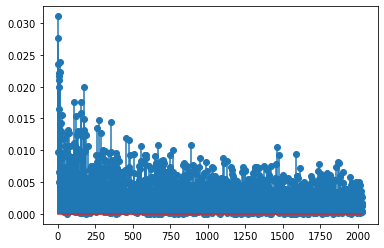

In [293]:
signal = daily_sentiment.bfill_imputed_score
smoothed = signal.rolling(window=10).mean()
dsp.dft_report(signal)

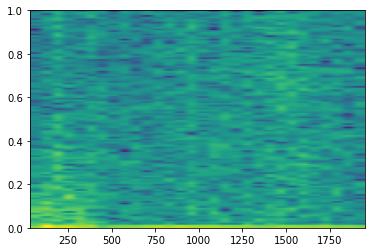

In [295]:
import matplotlib.pyplot as plt
plt.specgram(signal);

# Spark

In [7]:
df.show(2)

+----------+--------------------+--------------------+-------------------+--------+---------+--------+--------+
|        id|                link|             content|               date|retweets|favorites|mentions|hashtags|
+----------+--------------------+--------------------+-------------------+--------+---------+--------+--------+
|1698308935|https://twitter.c...|Be sure to tune i...|2009-05-04 13:54:25|     510|      917|    null|    null|
|1701461182|https://twitter.c...|Donald Trump will...|2009-05-04 20:00:10|      34|      267|    null|    null|
+----------+--------------------+--------------------+-------------------+--------+---------+--------+--------+
only showing top 2 rows



In [8]:
df.count()

43352

In [15]:
df = data.load_motionsense(frmt='spark', device='jog_9', subject=2)
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- attitude.roll: string (nullable = true)
 |-- attitude.pitch: string (nullable = true)
 |-- attitude.yaw: string (nullable = true)
 |-- gravity.x: string (nullable = true)
 |-- gravity.y: string (nullable = true)
 |-- gravity.z: string (nullable = true)
 |-- rotationRate.x: string (nullable = true)
 |-- rotationRate.y: string (nullable = true)
 |-- rotationRate.z: string (nullable = true)
 |-- userAcceleration.x: string (nullable = true)
 |-- userAcceleration.y: string (nullable = true)
 |-- userAcceleration.z: string (nullable = true)

